In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


# 1. Reading and understanidng and Visualising data
# 2. Preparing the data for modeling (train-test split, rescaling)
# 3. Trainng the model
# 4. Improve the model
# 5. Residual Analysis
# 6. Prediction and evalution on test

df = pd.read_csv("CarPrice_Assignment.csv")

#Dropping Car_ID, as it's not needed
df = df.drop(['car_ID'], axis=1)


#Creating new column for car company
df['car_comp'] = df['CarName'].apply(lambda x : x.split()[0])
df = df.drop(['CarName'], axis=1)



# Correcting spelling mistakes for car company and merging with their related one
df.car_comp = df.car_comp.str.lower()
df['car_comp'] = np.where(df['car_comp'] == 'vw', 'volkswagen', df['car_comp'])
df['car_comp'] = np.where(df['car_comp'] == 'vokswagen', 'volkswagen', df['car_comp'])
df['car_comp'] = np.where(df['car_comp'] == 'maxda', 'mazda', df['car_comp'])
df['car_comp'] = np.where(df['car_comp'] == 'toyouta', 'toyota', df['car_comp'])
df['car_comp'] = np.where(df['car_comp'] == 'porcshce', 'porsche', df['car_comp'])



#Removing car brands which has less than 4 entries only : Not usefule for analysis
count_of_entries_car_comp = df.groupby("car_comp").size()
list_car_comp=count_of_entries_car_comp[count_of_entries_car_comp<=3].index.tolist()



# Deleting rows, which has car company as above mentioned
df = df[~df['car_comp'].isin(list_car_comp)]

#seperate out numeric and categorical columns which will help us in plotting all the columns.

Numeric_Col=df.select_dtypes(include=[np.number]).columns.tolist()
categoricl_var=df.select_dtypes(exclude=[np.number]).columns.tolist()

#Remove 'price' column
Numeric_Col = Numeric_Col[0:-1]
Numeric_Col.remove('symboling')
categoricl_var.append('symboling')


#Removing outliers and imputing with their median
df.enginesize = df.enginesize[df.enginesize.between(df.enginesize.quantile(.25), df.enginesize.quantile(.75))]
df.horsepower = df.horsepower[df.horsepower.between(df.horsepower.quantile(.25), df.horsepower.quantile(.75))]
df.fillna(df.median(),inplace=True)


#Plotting pairplot of numeric variables  with price
plt.figure(figsize=(35,27))
sns.pairplot(df, x_vars=Numeric_Col, y_vars='price',kind='scatter')
plt.show()



#-------------------------- Categorical------------------------------



# ---------------Checking with box-plot------------------
 
plt.figure(figsize=(20,12))
indx=1
for val in categoricl_var:
    plt.subplot(4,3,indx)
    val =val.lower().strip()
    sns.boxplot(x=val, y='price', data=df)
    indx += 1




# Defining the map function
def digit_map(x):
    return x.map({'-3': 'symboling_Minus3','-2': 'symboling_Minus2', '-1': 'symboling_Minus1','0': 'symboling_zero', '1': 'symboling_One', '2': 'symboling_Two', '3': 'symboling_Three'})

# Defining the map function
def cardoor_map(x):
    return x.map({ 'two': 'doornumber_2', 'four': 'doornumber_4'})

                   
                   
# Applying the function to the housing list
vars=['symboling']
df[vars] = df[vars].astype(str).apply(digit_map)
vars=['doornumber']
df[vars] = df[vars].apply(cardoor_map)



#Create dummy variables for categorical columns:
for val in categoricl_var:
    d1 = pd.get_dummies(df[val], drop_first=True)
    df = pd.concat([df,d1], axis=1)
                   

#Drooping columns, as we have created dummy variables for them                   
col = ['car_comp', 'enginetype', '4bbl', 'spfi', 'mfi', 'spdi', 'dohcv', 'rotor','fuelsystem','cylindernumber','symboling','carbody','doornumber','drivewheel','fueltype','aspiration','enginelocation']
df = df.drop(col, axis=1)
df=df.reset_index(drop=True)


#Checking, what are the variables highly/moderate correlated (positive and negative)
df_corr_with_price =round(df.corr()['price'],2)
df_corr_with_price = df_corr_with_price.sort_values()
df_corr_with_price = df_corr_with_price.loc[(df_corr_with_price > 0.4) & (df_corr_with_price < 1.0) | (df_corr_with_price < -0.5)]
useless_numeric_column = [x for x in Numeric_Col if x not in df_corr_with_price.index.tolist()]

#Dropping those variables which are weakly correlated with price
df = df.drop(useless_numeric_column, axis=1)
df.head()

<Figure size 3500x2700 with 0 Axes>

<Figure size 3250x250 with 13 Axes>

,wheelbase,carlength,carwidth,curbweight,boreratio,citympg,highwaympg,price,gas,turbo,...,saab,subaru,toyota,volkswagen,volvo,symboling_Minus2,symboling_One,symboling_Three,symboling_Two,symboling_zero
0,99.8,176.6,66.2,2337,3.19,24,30,13950.0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,99.4,176.6,66.4,2824,3.19,18,22,17450.0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,99.8,177.3,66.3,2507,3.19,19,25,15250.0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,105.8,192.7,71.4,2844,3.19,19,25,17710.0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,105.8,192.7,71.4,2954,3.19,19,25,18920.0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [2]:
from sklearn.model_selection import train_test_split

#Split test and train data 
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)


# Scaling numeric variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = df_corr_with_price.index.tolist()
num_vars.append('price')
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])


### Dividing into X and Y sets for the model building

In [3]:
# Dividing into X and Y sets for the model building
y_train = df_train['price']
X_train = df_train.drop(['price'], axis=1)


In [4]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)
print(len(X_train.columns))

49


In [5]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)
X_train_rfe.shape
lm = sm.OLS(y_train,X_train_rfe).fit()   
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     89.82
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           8.89e-60
Time:                        16:51:35   Log-Likelihood:                 202.75
No. Observations:                 135   AIC:                            -365.5
Df Residuals:                     115   BIC:                            -307.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1951      0.078      2.503      0.0

In [6]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
20,subaru,inf
9,rear,inf
11,ohcf,inf
0,const,240.580000
14,four,34.790000
7,sedan,20.070000
15,six,16.380000
6,hatchback,15.240000
2,carlength,12.250000
4,curbweight,11.850000


### Now, I'll improve my model by remove variable which has infinte IVF and not significant (High  P-value)

In [7]:
X_train_new = X_train_rfe.drop(["subaru"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     89.82
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           8.89e-60
Time:                        16:51:35   Log-Likelihood:                 202.75
No. Observations:                 135   AIC:                            -365.5
Df Residuals:                     115   BIC:                            -307.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1951      0.078      2.503      0.0

,Features,VIF
0,const,240.58
14,four,34.79
7,sedan,20.07
15,six,16.38
6,hatchback,15.24
2,carlength,12.25
4,curbweight,11.85
8,wagon,11.30
13,five,10.29
1,wheelbase,8.39


In [8]:
X_train_new = X_train_new.drop(["wheelbase"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     95.30
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.08e-60
Time:                        16:51:35   Log-Likelihood:                 202.53
No. Observations:                 135   AIC:                            -367.1
Df Residuals:                     116   BIC:                            -311.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1953      0.078      2.512      0.0

,Features,VIF
0,const,240.58
13,four,34.52
6,sedan,18.83
14,six,16.36
5,hatchback,14.64
3,curbweight,11.83
7,wagon,10.44
12,five,10.09
1,carlength,9.74
2,carwidth,6.98


In [9]:
X_train_new = X_train_new.drop(["sedan"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     101.1
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.48e-61
Time:                        16:51:35   Log-Likelihood:                 202.13
No. Observations:                 135   AIC:                            -368.3
Df Residuals:                     117   BIC:                            -316.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1740      0.073      2.375      0.0

,Features,VIF
0,const,214.34
12,four,33.54
13,six,15.47
3,curbweight,10.96
11,five,9.67
1,carlength,8.58
2,carwidth,6.96
14,two,5.15
7,rear,4.37
10,ohcv,3.78


In [10]:
X_train_new = X_train_new.drop(["hatchback"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     107.3
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           2.41e-62
Time:                        16:51:35   Log-Likelihood:                 201.50
No. Observations:                 135   AIC:                            -369.0
Df Residuals:                     118   BIC:                            -319.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1685      0.073      2.305      0.0

,Features,VIF
0,const,213.24
11,four,33.34
12,six,15.45
3,curbweight,10.47
10,five,9.65
1,carlength,7.09
2,carwidth,6.80
13,two,5.02
6,rear,4.36
9,ohcv,3.77


In [11]:
X_train_new = X_train_new.drop(["ohcf"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     114.4
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           3.58e-63
Time:                        16:51:35   Log-Likelihood:                 200.94
No. Observations:                 135   AIC:                            -369.9
Df Residuals:                     119   BIC:                            -323.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1698      0.073      2.322      0.0

,Features,VIF
0,const,213.18
10,four,33.28
11,six,15.44
3,curbweight,10.44
9,five,9.65
1,carlength,7.09
2,carwidth,6.78
12,two,5.02
6,rear,4.03
8,ohcv,3.77


In [12]:
X_train_new = X_train_new.drop(["carlength"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     122.1
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           6.19e-64
Time:                        16:51:35   Log-Likelihood:                 200.18
No. Observations:                 135   AIC:                            -370.4
Df Residuals:                     120   BIC:                            -326.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1615      0.073      2.216      0.0

,Features,VIF
0,const,211.16
9,four,33.28
10,six,15.33
8,five,9.58
2,curbweight,6.68
1,carwidth,5.50
11,two,4.99
5,rear,3.91
7,ohcv,3.65
13,buick,3.42


In [13]:
X_train_new = X_train_new.drop(["ohcv"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     130.0
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.60e-64
Time:                        16:51:35   Log-Likelihood:                 198.93
No. Observations:                 135   AIC:                            -369.9
Df Residuals:                     121   BIC:                            -329.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1051      0.063      1.677      0.0

,Features,VIF
0,const,154.83
8,four,23.37
9,six,14.46
2,curbweight,6.68
7,five,5.95
1,carwidth,5.49
10,two,3.74
5,rear,3.63
12,buick,3.42
13,porsche,3.10


In [14]:
X_train_new = X_train_new.drop(["hardtop"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     139.0
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           4.37e-65
Time:                        16:51:35   Log-Likelihood:                 197.59
No. Observations:                 135   AIC:                            -369.2
Df Residuals:                     122   BIC:                            -331.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1234      0.062      1.992      0.0

,Features,VIF
0,const,149.42
7,four,22.35
8,six,14.05
2,curbweight,6.60
6,five,5.63
1,carwidth,5.47
9,two,3.63
4,rear,3.45
11,buick,3.28
12,porsche,3.10


In [15]:
X_train_new = X_train_new.drop(["two"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     148.0
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           2.21e-65
Time:                        16:51:36   Log-Likelihood:                 195.54
No. Observations:                 135   AIC:                            -367.1
Df Residuals:                     123   BIC:                            -332.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0237      0.035      0.677      0.4

,Features,VIF
0,const,46.40
2,curbweight,6.60
7,four,6.25
1,carwidth,5.29
8,six,5.27
4,rear,3.43
11,porsche,3.09
6,five,2.54
10,buick,2.21
5,l,1.51


In [16]:
X_train_new = X_train_new.drop(["wagon"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     158.7
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.16e-65
Time:                        16:51:36   Log-Likelihood:                 193.42
No. Observations:                 135   AIC:                            -364.8
Df Residuals:                     124   BIC:                            -332.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0256      0.035      0.726      0.4

,Features,VIF
0,const,46.36
6,four,6.22
2,curbweight,5.65
7,six,5.23
1,carwidth,4.95
3,rear,3.43
10,porsche,3.09
5,five,2.53
9,buick,2.13
4,l,1.51


In [17]:
X_train_new = X_train_new.drop(["six"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     170.5
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           9.33e-66
Time:                        16:51:36   Log-Likelihood:                 190.82
No. Observations:                 135   AIC:                            -361.6
Df Residuals:                     125   BIC:                            -332.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0222      0.028     -0.783      0.4

,Features,VIF
0,const,28.94
2,curbweight,5.20
1,carwidth,4.83
3,rear,3.37
9,porsche,3.09
6,four,2.67
5,five,1.73
8,buick,1.59
4,l,1.48
7,bmw,1.28


In [18]:
X_train_new = X_train_new.drop(["l"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     185.8
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           6.36e-66
Time:                        16:51:36   Log-Likelihood:                 188.36
No. Observations:                 135   AIC:                            -358.7
Df Residuals:                     126   BIC:                            -332.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.026      0.171      0.8

,Features,VIF
0,const,23.43
1,carwidth,4.81
2,curbweight,4.57
3,rear,3.34
8,porsche,3.05
5,four,2.32
4,five,1.73
7,buick,1.50
6,bmw,1.27


In [19]:
X_train_new = X_train_new.drop(["five"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     200.6
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.86e-65
Time:                        16:51:36   Log-Likelihood:                 184.32
No. Observations:                 135   AIC:                            -352.6
Df Residuals:                     127   BIC:                            -329.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0123      0.026     -0.475      0.6

,Features,VIF
0,const,22.18
1,carwidth,4.19
2,curbweight,4.10
3,rear,3.33
7,porsche,3.05
4,four,1.93
6,buick,1.47
5,bmw,1.24


In [20]:
X_train_new = X_train_new.drop(["porsche"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     219.1
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           8.44e-65
Time:                        16:51:36   Log-Likelihood:                 179.78
No. Observations:                 135   AIC:                            -345.6
Df Residuals:                     128   BIC:                            -325.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0217      0.026     -0.821      0.4

,Features,VIF
0,const,21.85
1,carwidth,4.11
2,curbweight,4.09
4,four,1.91
6,buick,1.47
5,bmw,1.24
3,rear,1.16


In [21]:
X_train_new = X_train_new.drop(["four"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     249.2
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.78e-64
Time:                        16:51:36   Log-Likelihood:                 176.01
No. Observations:                 135   AIC:                            -340.0
Df Residuals:                     129   BIC:                            -322.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0825      0.014     -5.814      0.0

,Features,VIF
0,const,6.02
2,curbweight,4.03
1,carwidth,3.93
5,buick,1.41
4,bmw,1.10
3,rear,1.05


In [22]:
X_train_new = X_train_new.drop(["const"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     249.2
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           1.78e-64
Time:                        16:51:36   Log-Likelihood:                 176.01
No. Observations:                 135   AIC:                            -340.0
Df Residuals:                     129   BIC:                            -322.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0825      0.014     -5.814      0.0

,Features,VIF
1,curbweight,15.92
0,carwidth,14.92
4,buick,1.25
3,bmw,1.15
2,rear,1.06


In [23]:
X_train_new = X_train_new.drop(["curbweight"], axis = 1)
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm.summary())

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     233.0
Date:                Mon, 26 Aug 2019   Prob (F-statistic):           2.95e-58
Time:                        16:51:36   Log-Likelihood:                 158.06
No. Observations:                 135   AIC:                            -306.1
Df Residuals:                     130   BIC:                            -291.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0780      0.016     -4.836      0.0

,Features,VIF
0,carwidth,1.29
3,buick,1.22
2,bmw,1.06
1,rear,1.01


### Making predictions on train data


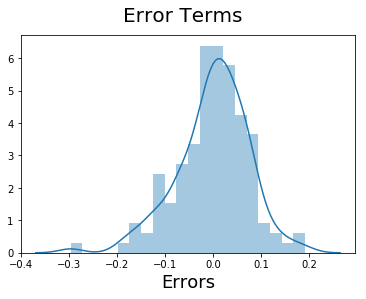

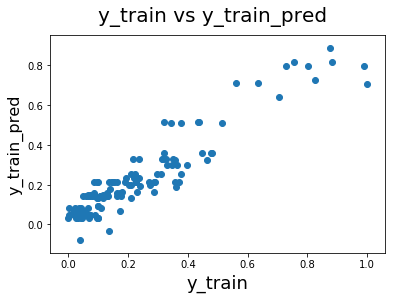

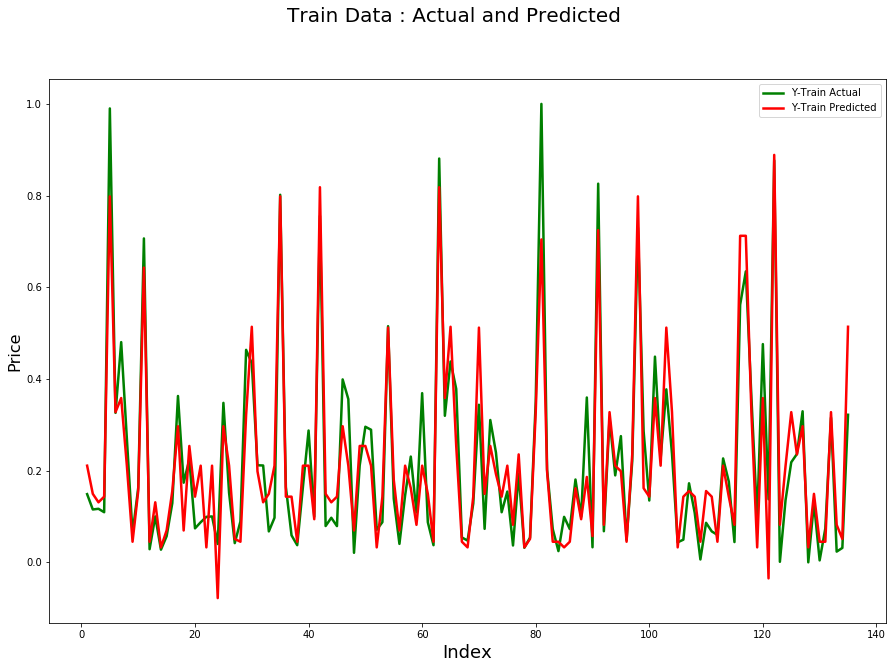

In [24]:
# Making predictions on train data
y_train_pred = lm.predict(X_train_lm)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train_pred - y_train), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18)                         


# Plotting y_train and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_train,y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize=20)              
plt.xlabel('y_train', fontsize=18)                          
plt.ylabel('y_train_pred', fontsize=16) 



#Actual vs Predicted : Training Data
c = [i for i in range(1,136,1)]
fig = plt.figure(figsize=(15,10))
plt.plot(c,y_train, color="green", linewidth=2.5, linestyle="-")
plt.plot(c,y_train_pred, color="red",  linewidth=2.5, linestyle="-")
# Plot heading 
fig.suptitle('Train Data : Actual and Predicted', fontsize=20) 
# X-label
plt.xlabel('Index', fontsize=18)                               
# Y-label
plt.ylabel('Price', fontsize=16)                               
plt.legend(['Y-Train Actual', 'Y-Train Predicted'], loc='upper right')


### Now, We will predict on test data :

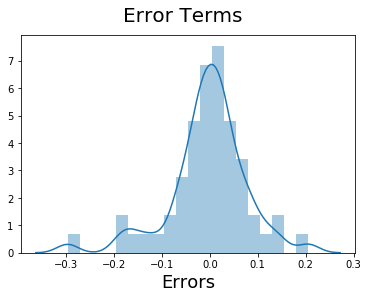

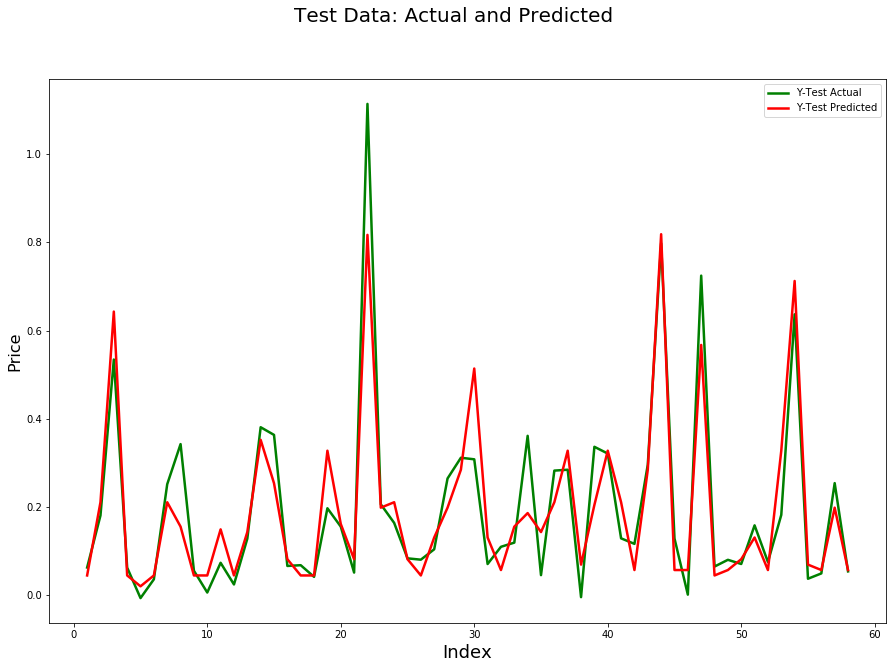

In [25]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

df_test.head()
y_test = df_test['price']
X_test = df_test

# Adding a constant variable 

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)

# Making predictions
y_pred = lm.predict(X_test_new)

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_pred - y_test), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label


#Let's plot Actual vs Predicted :
 
c = [i for i in range(1,59,1)]
fig = plt.figure(figsize=(15,10))
plt.plot(c,y_test, color="green", linewidth=2.5, linestyle="-")
plt.plot(c,y_pred, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Test Data: Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Price', fontsize=16)                               # Y-label
plt.legend(['Y-Test Actual', 'Y-Test Predicted'], loc='upper right')
  

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score(y_test, y_pred)


0.8517886634501178